In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')
sys.path.append('../hovernet')
sys.path.append('../deconvplugin')

import json
import os
import pickle
import torch
import scanpy as sc

PATH = '/home/luca/Documents/data/'

#'/cluster/CBIO/data1/lgortana/'
#'/home/luca/Documents/data/'

/home/luca/anaconda3/envs/plugin-env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load data

In [2]:
# names
adata_name = 'CytAssist_11mm_FFPE_Human_Ovarian_Carcinoma'
sim_tag = "6_moco_clusters_700spots_balanced_15mean_15var"
model_tag = "model_resnet18_alpha_0.0_lr_0.0001_weights_True_divergence_l2_seed_42"

In [3]:
import pandas as pd

data_path = os.path.join(PATH, adata_name)
sim_path = os.path.join(data_path, "sim")

#load image_dict
image_dict = torch.load(os.path.join(sim_path, f'{sim_tag}_image_dict_64.pt'))

#load ground truth
ground_truth = pd.read_csv(os.path.join(sim_path, f'{sim_tag}_gt.csv'), index_col=0)
ground_truth.index = ground_truth.index.astype(str)

In [4]:
#load model infos
model_dir = os.path.join('../models/sim', sim_tag, model_tag)

with open(os.path.join(model_dir, 'info.pickle'), 'rb') as f:
    model_info = pickle.load(f)

# Analysis

In [138]:
from deconvplugin.analysis.pred_analyzer import PredAnalyzer

analyzer = PredAnalyzer(model_info=model_info,
                        model_state="best",
                        adjusted=False,
                        ground_truth=ground_truth, 
                        image_dict=image_dict
                        )

Loading predicted labels...
Loading true labels...
Use `add_attributes(seg_dict=your_seg_dict)` to add one.


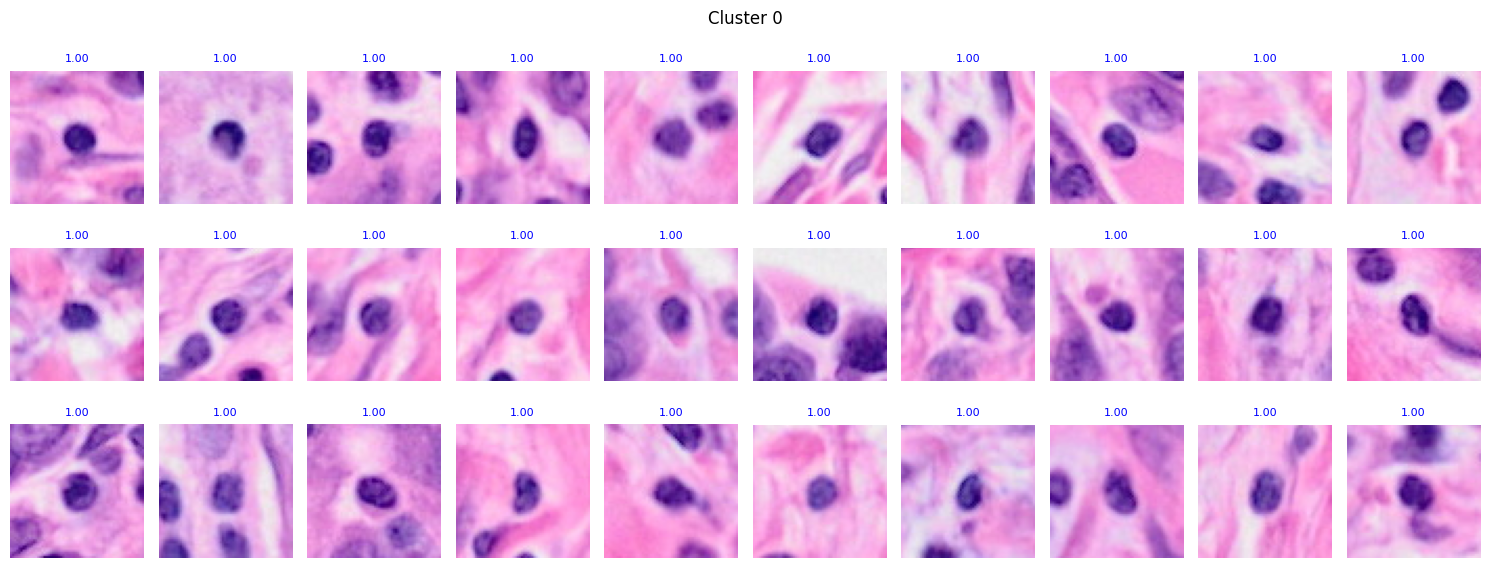

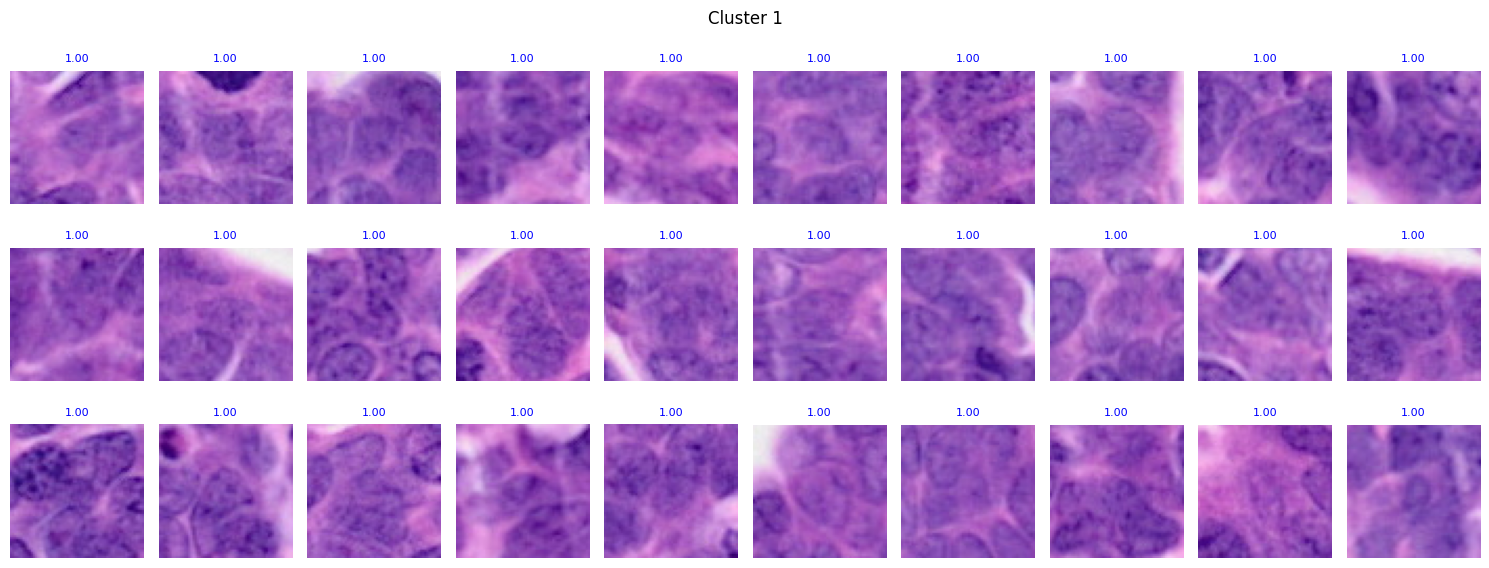

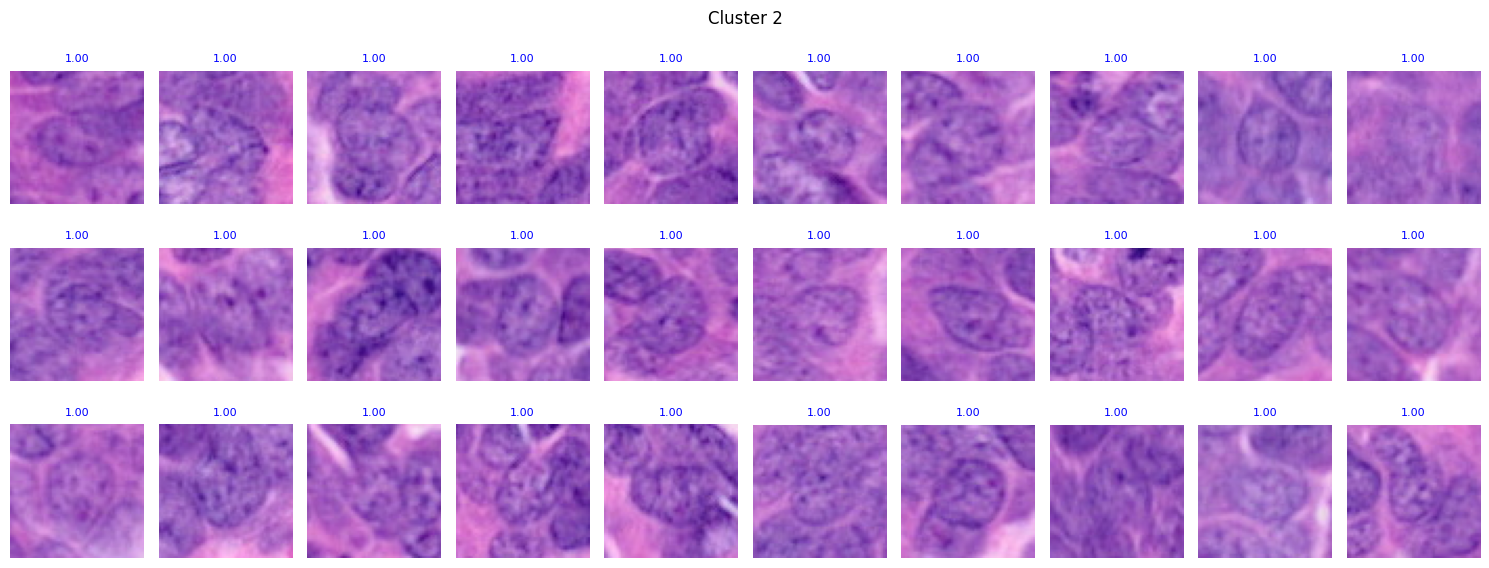

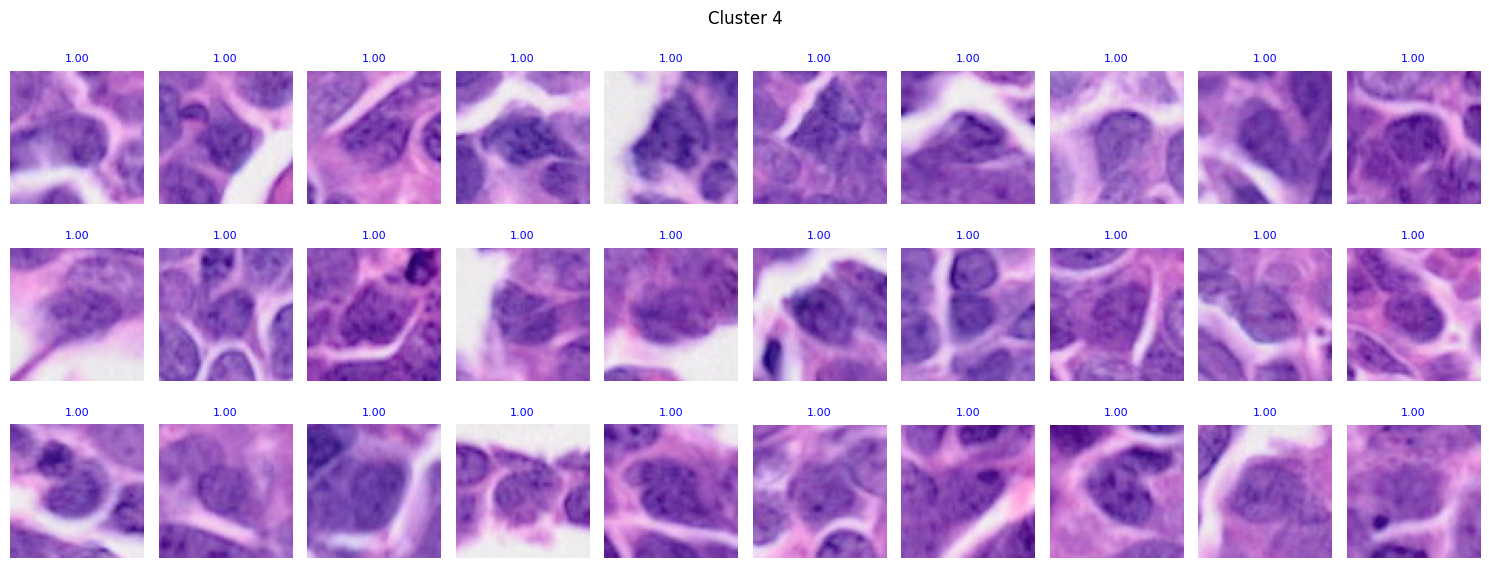

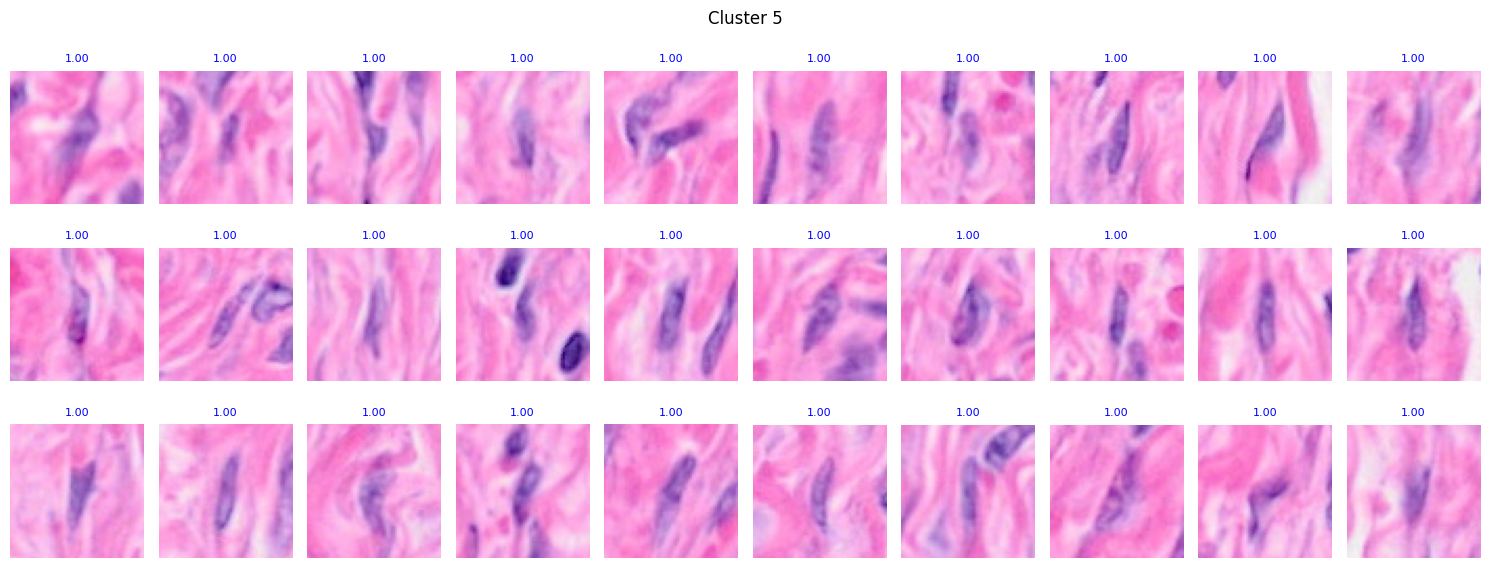

In [139]:
for ct in analyzer.ct_list:
    analyzer.plot_grid_celltype(cell_type=ct, n=30, selection="max", display=True)

In [72]:
analyzer.plot_mosaic_cells(spot_id=None)

Randomly selected spot_id: 619


In [166]:
analyzer.evaluate_spot_predictions()

{'Spearman Correlation': 0.9097294787798322,
 'Pearson Correlation': 0.9577053370815508,
 'Weighted MSE': 0.00013177169208141402,
 'MSE': 0.0007969944361764586,
 'Weighted MAE': 0.0018217211327366447,
 'MAE': 0.01099511777628586,
 'R^2 Score': 0.9287855793832535,
 'Balanced Accuracy': 0.8171882050193308,
 'Weighted F1 Score': 0.7969537701842324,
 'Weighted Precision': 0.8186964956889753,
 'Weighted Recall': 0.7971428571428572}

In [167]:
perf = analyzer.evaluate_cell_predictions()
perf

{'Global Accuracy': 0.9553881233270546,
 'Balanced Accuracy': 0.9555295162252304,
 'Weighted F1 Score': 0.9553333742212121,
 'F1 Score (Per Class)': {'Cluster 0': 0.9904648390941597,
  'Cluster 1': 0.9292452830188679,
  'Cluster 2': 0.9669669669669669,
  'Cluster 3': 0.92463509085493,
  'Cluster 4': 0.9484597156398105,
  'Cluster 5': 0.9729408266428784},
 'Weighted Precision': 0.95535242428488,
 'Precision (Per Class)': {'Cluster 0': 0.9851807943094251,
  'Cluster 1': 0.9221767115272089,
  'Cluster 2': 0.971049457177322,
  'Cluster 3': 0.9326923076923077,
  'Cluster 4': 0.9535437760571769,
  'Cluster 5': 0.9680473372781065},
 'Weighted Recall': 0.9553881233270546,
 'Recall (Per Class)': {'Cluster 0': 0.9958058717795086,
  'Cluster 1': 0.936423054070113,
  'Cluster 2': 0.9629186602870813,
  'Cluster 3': 0.9167158889545186,
  'Cluster 4': 0.943429581614614,
  'Cluster 5': 0.9778840406455469},
 'Confusion Matrix':            Cluster 0  Cluster 1  Cluster 2  Cluster 3  Cluster 4  Cluster 5

In [75]:
pd.DataFrame(perf["Confusion Matrix"], index=analyzer.ct_list, columns=analyzer.ct_list)

Cluster 0  Cluster 1  Cluster 2  Cluster 3  Cluster 4  Cluster 5
Cluster 0       1346          0          0          6          1          5
Cluster 1          0        599         23         17         37          0
Cluster 2          0         24       1340          1          1          0
Cluster 3          6          9          1       1183         30         26
Cluster 4          0         12          0         28       1691          0
Cluster 5          3          0          0         18          0        663

# Gridsearch

In [177]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

summary = pd.read_csv("../models/sim/6_moco_clusters_700spots_212361_15mean_15var/summary_metrics_cells_best_adj.csv")
metric_interest = "Balanced Accuracy"

summary.insert(0, "model_name", "")
mid_index = len(summary) // 2
summary.loc[:mid_index, "model_name"] = "resnet18"
summary.loc[mid_index:, "model_name"] = "resnet50"

columns_of_interest = ["model_name", "alpha", "lr", "weights", "divergence", metric_interest]
summary = summary[columns_of_interest]

summary["weights"] = summary["weights"].astype(bool)
summary["alpha"] = summary["alpha"].astype(float)
summary["lr"] = summary["lr"].astype(float)

In [178]:
def plot_balanced_accuracy(model, df, ax):
    subset = df[df["model_name"] == model]
    divergences = subset["divergence"].unique()
    x = np.arange(len(divergences))
    width = 0.12
    
    lr_values = [0.0001, 0.00001]
    num_groups = 8
    
    
    
    for i, alpha in enumerate([0.0, 0.01]):
        for j, lr in enumerate(lr_values):
            for k, weights in enumerate([False, True]):
                color = "#99e699" if alpha == 0.0 else "#66b3ff"
                hatch = "//" if lr == 0.0001 else ""
                marker = "*" if weights else ""
                edgecolor = "black"
                
                values = [
                    subset[
                        (subset["divergence"] == d) & 
                        (subset["weights"] == weights) & 
                        (subset["alpha"] == alpha) & 
                        (subset["lr"] == lr)
                    ][metric_interest].mean()
                    for d in divergences
                ]
                
                group_index = i * 4 + j * 2 + k
                bar_positions = x + (group_index - (num_groups / 2)) * width
                
                bars = ax.bar(bar_positions, values, width, color=color, hatch=hatch, edgecolor=edgecolor, linewidth=0.6)

                for bar in bars:
                    if marker:
                        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), marker,
                                ha='center', fontsize=12, color='black')
    
    ax.set_xticks(x)
    ax.set_xticklabels(divergences)
    ax.set_xlabel("Divergence")
    ax.set_ylabel(metric_interest)
    ax.set_title(f"{model}")

In [179]:

fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
plot_balanced_accuracy("resnet18", summary, axes[0])
plot_balanced_accuracy("resnet50", summary, axes[1])

legend_elements = [
    mpatches.Patch(color="#66b3ff", label="α=0.01"),
    mpatches.Patch(color="#99e699", label="α=0.0"),
    mpatches.Patch(facecolor="white", edgecolor="black", hatch="//", label="LR=1e-4"),
    mpatches.Patch(facecolor="white", edgecolor="black", label="LR=1e-5"),
    mpatches.Patch(facecolor="none", edgecolor="none", hatch='*', linewidth=0.8, label="* weights"),
]

legend = axes[0].legend(handles=legend_elements, loc="upper left", fontsize=12, frameon=True, title_fontsize=13)
legend.get_frame().set_linewidth(1.2)
legend.get_frame().set_edgecolor("black")

plt.tight_layout()
plt.show()

In [5]:
from deconvplugin.basics import load_model

model = load_model(model_dir+"/best_model.pth", model_name="resnet18", num_classes=6, hidden_dims=[])

Device found to load the model :  cpu


In [120]:
from deconvplugin.dataset import SpotDataset
from deconvplugin.dataset_utils import custom_collate
from deconvplugin.dataset_utils import split_data

spot_dict = model_info["spot_dict"]
spot_prop_df = model_info["proportions"]

train_spot_dict, train_proportions, val_spot_dict, val_proportions, test_spot_dict, test_proportions = split_data(
        spot_dict, spot_prop_df, train_size=0.7, val_size=0.15, rs=42
    )

train_dataset = SpotDataset(train_spot_dict, train_proportions, image_dict, None)
val_dataset = SpotDataset(val_spot_dict, val_proportions, image_dict, None)
test_dataset = SpotDataset(test_spot_dict, test_proportions, image_dict, None)

# Create dataloaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=5, shuffle=True, collate_fn=custom_collate)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=5, shuffle=False, collate_fn=custom_collate)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=5, shuffle=False, collate_fn=custom_collate)

In [7]:
batch = next(iter(train_loader))

In [9]:
images = batch["images"]
proportions = batch["proportions"]
bag_indices = batch["bag_indices"]

In [62]:
bag_indices

tensor([465, 465, 465, 465, 465, 465, 465, 465, 465, 465, 253, 253, 253, 253,
        253, 253, 253, 253, 253, 375, 375, 375, 375, 375, 375, 375, 375, 375,
        375, 375, 375, 375, 375, 375, 154, 154, 154, 154, 154, 154, 154, 154,
        154, 154, 154, 154, 154, 154, 239, 239, 239, 239, 239, 239, 239, 239,
        239, 239, 239, 239, 239, 239, 239, 239, 239, 239])

In [55]:
unique_vals = torch.unique(bag_indices, sorted=False).flip(0)
mapping = {val.item(): idx for idx, val in enumerate(unique_vals)}
new_bag_indices = torch.tensor([mapping[val.item()] for val in bag_indices])
new_bag_indices

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4])

In [56]:
cell_probs = model(images)

In [57]:
from torch_scatter import scatter_mean

spot_probs = scatter_mean(cell_probs, new_bag_indices, dim=0)

In [88]:
spot_probs

tensor([[1.0003e-01, 9.9912e-02, 2.9996e-01, 1.9678e-01, 1.9998e-01, 1.0334e-01],
        [2.2156e-01, 1.1113e-01, 1.1112e-01, 3.3393e-01, 2.2224e-01, 1.8793e-05],
        [3.3276e-01, 2.6624e-01, 1.3360e-01, 6.7229e-02, 6.6786e-02, 1.3339e-01],
        [2.1430e-01, 2.8635e-01, 1.4313e-01, 1.4166e-01, 7.1349e-02, 1.4321e-01],
        [1.1097e-01, 1.6608e-01, 1.6704e-01, 1.6510e-01, 1.6695e-01, 2.2386e-01]],
       grad_fn=<DivBackward0>)

In [63]:
spot_prop_df.loc[train_dataset.spot_ids[465]]

Cluster 0    0.1
Cluster 1    0.1
Cluster 2    0.3
Cluster 3    0.2
Cluster 4    0.2
Cluster 5    0.1
Name: 191, dtype: float64

In [58]:
spot_probs

tensor([[1.0003e-01, 9.9912e-02, 2.9996e-01, 1.9678e-01, 1.9998e-01, 1.0334e-01],
        [2.2156e-01, 1.1113e-01, 1.1112e-01, 3.3393e-01, 2.2224e-01, 1.8793e-05],
        [3.3276e-01, 2.6624e-01, 1.3360e-01, 6.7229e-02, 6.6786e-02, 1.3339e-01],
        [2.1430e-01, 2.8635e-01, 1.4313e-01, 1.4166e-01, 7.1349e-02, 1.4321e-01],
        [1.1097e-01, 1.6608e-01, 1.6704e-01, 1.6510e-01, 1.6695e-01, 2.2386e-01]],
       grad_fn=<DivBackward0>)

In [64]:
proportions

tensor([[0.1000, 0.1000, 0.3000, 0.2000, 0.2000, 0.1000],
        [0.2222, 0.1111, 0.1111, 0.3333, 0.2222, 0.0000],
        [0.3333, 0.2667, 0.1333, 0.0667, 0.0667, 0.1333],
        [0.2143, 0.2857, 0.1429, 0.1429, 0.0714, 0.1429],
        [0.1111, 0.1667, 0.1667, 0.1667, 0.1667, 0.2222]])

In [77]:
weights=torch.tensor([1, 1, 1, 1, 1, 1])
max_probs, max_indices = cell_probs.max(dim=1)
max_weights = weights[max_indices]
max_prob_loss = -max_weights * torch.log(max_probs)

In [92]:
from deconvplugin.loss import weighted_l1_loss

loss = weighted_l1_loss(spot_probs, proportions, weights, reduction="mean")
loss

tensor(0.0006, grad_fn=<MeanBackward0>)

In [129]:
example_img = proportions[0]
size = (example_img.shape[1], example_img.shape[1])

IndexError: tuple index out of range

In [97]:
(weights * torch.abs(spot_probs - proportions)).mean(dim=1).mean()

tensor(0.0006, grad_fn=<MeanBackward0>)

In [79]:
max_prob_scatter_loss = scatter_mean(max_prob_loss, new_bag_indices, dim=0)

In [87]:
-torch.mean(max_weights * torch.log(max_probs))

tensor(0.0028, grad_fn=<NegBackward0>)

In [85]:
max_prob_scatter_loss.mean()

tensor(0.0028, grad_fn=<MeanBackward0>)

In [81]:
spot_probs

tensor([[1.0003e-01, 9.9912e-02, 2.9996e-01, 1.9678e-01, 1.9998e-01, 1.0334e-01],
        [2.2156e-01, 1.1113e-01, 1.1112e-01, 3.3393e-01, 2.2224e-01, 1.8793e-05],
        [3.3276e-01, 2.6624e-01, 1.3360e-01, 6.7229e-02, 6.6786e-02, 1.3339e-01],
        [2.1430e-01, 2.8635e-01, 1.4313e-01, 1.4166e-01, 7.1349e-02, 1.4321e-01],
        [1.1097e-01, 1.6608e-01, 1.6704e-01, 1.6510e-01, 1.6695e-01, 2.2386e-01]],
       grad_fn=<DivBackward0>)

In [112]:
loss, loss_half1, loss_half2 = model.compute_loss(
    cell_probs,
    new_bag_indices,
    proportions,
    weights=None,
    agg="proba",
    divergence="l2",
    reduction="mean",
    alpha=0,
)

In [117]:
len(train_loader)

98

In [106]:
max_probs, max_indices = cell_probs.max(dim=1)

In [110]:
torch.ones_like(proportions)[0]

tensor([1., 1., 1., 1., 1., 1.])

In [108]:
max_probs, max_indices

(tensor([0.9999, 0.9881, 0.9968, 0.9998, 0.9993, 0.9999, 1.0000, 0.9999, 0.9995,
         0.9568, 0.9946, 1.0000, 1.0000, 0.9998, 0.9999, 1.0000, 0.9995, 0.9993,
         0.9997, 0.9998, 0.9980, 0.9971, 0.9999, 0.9998, 0.9963, 0.9991, 0.9972,
         1.0000, 0.9993, 0.9994, 0.9999, 0.9985, 0.9970, 0.9992, 0.9819, 0.9996,
         0.9997, 0.9997, 1.0000, 1.0000, 1.0000, 0.9998, 0.9943, 0.9967, 0.9999,
         0.9986, 0.9996, 0.9999, 0.9997, 0.9999, 0.9739, 0.9998, 0.9997, 0.9998,
         0.9999, 0.9912, 0.9999, 0.9961, 0.9976, 0.9994, 0.9938, 0.9999, 0.9963,
         0.9983, 0.9980, 0.9879], grad_fn=<MaxBackward0>),
 tensor([2, 4, 1, 5, 2, 4, 0, 3, 2, 3, 0, 4, 3, 3, 3, 4, 1, 0, 2, 2, 1, 0, 5, 5,
         1, 3, 1, 4, 0, 2, 1, 0, 0, 0, 3, 5, 1, 0, 5, 2, 2, 1, 4, 1, 0, 1, 3, 0,
         5, 4, 3, 2, 5, 2, 3, 3, 5, 1, 1, 5, 4, 0, 0, 4, 2, 1]))